In [1]:

# Imports
import pandas as pd
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest,chi2,RFE
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble._bagging import BaggingClassifier
from sklearn.ensemble._forest import ExtraTreesClassifier

from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble._bagging import BaggingClassifier
from sklearn.metrics import confusion_matrix, fbeta_score

from fairlearn.metrics import MetricFrame
from fairlearn.metrics import selection_rate, count
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import ExponentiatedGradient, ClassificationMoment, Moment, DemographicParity, GridSearch
from fairlearn.metrics import equalized_odds_difference, equalized_odds_ratio, false_negative_rate_difference, false_positive_rate_difference, true_positive_rate_difference, true_negative_rate_difference, demographic_parity_ratio, demographic_parity_difference

# Suppress warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn import svm
from sklearn.naive_bayes import CategoricalNB


In [3]:
# Setting parameters

alpha = 0.1 # Statistical significance for chi2 test. 
k = 3 # Minimum number of feature selection method selecting a given feature. 

models_to_train = [
     LogisticRegression, 
    RandomForestClassifier, 
     DecisionTreeClassifier, 
   # XGBClassifier, 
     BaggingClassifier,
   # AdaBoostClassifier,
    
]


unfairness_metrics = [
    selection_rate, 
    fbeta_score, 
    equalized_odds_difference, 
    equalized_odds_ratio
]
model_evaulation = [
    accuracy_score, 
    recall_score, 
    precision_score, 
    f1_score 
]

demographic_features = [
    'RACE', 
    'FEMALE', 
    'PAY1', 
    'ZIPINC_QRTL', 
    'AGE'
]

# Choose the appropriate variable for selected features depending on the dataset being used. 
# Keep all categorical features numeric. 



In [7]:
file_path = 'data.csv'

In [8]:
df=pd.read_csv(file_path)

# Preprocessing

In [86]:
def fillSpace(x):
    if x =='':
        return 999999
    else:
        return x
        
for i in df.columns:
    df[i]=df[i].apply(fillSpace)

## Remove outliers 

In [31]:
df.loc[df["LOS"] == "C", "LOS"] = 0

In [32]:
df.LOS=pd.to_numeric(df.LOS, errors ='coerce')

In [34]:
def los_category(x):
    if x <= 5:
        return 0

    return 1
df['LOS_category']=df['LOS'].apply(los_category)

## Decode RACE

In [39]:
def get_race(x):
    if x == 1 or x == "1":
         return 1
    elif x == 2 or x == "2":
        return 2
    elif x == 3 or x =="3":
        return 3
    elif x == 4 or x =="4":
        return 4
    else:
        return 5
    
df['RACE'] = df['RACE'].apply(get_race)

In [40]:
df['RACE'].value_counts()

1    510062
3    164595
2     43548
5     38048
4     15244
Name: RACE, dtype: int64

## Fix Age inconsistencies 

In [42]:
#Remove null and outliers of AGE
df.loc[df["AGE"] == "C", "AGE"] = 999999
df = df[df.AGE.notnull()]
df["AGE"]= df["AGE"].astype(int)

In [46]:
df['AGE'].value_counts()

6    207074
0    118667
5    117584
1    100386
4     89239
2     77870
3     60669
Name: AGE, dtype: int64

In [44]:
def age(x):
    if x < 18:
         return 0
    elif 18 <= x <= 30:
        return 1
    elif 30 < x <= 40:
        return 2
    elif 40 < x <= 50:
        return 3
    elif 50 < x <= 60:
        return 4
    elif 60 < x <= 70:
        return 5
    elif 70 < x:
        return 6
        
    
df['AGE'] = df['AGE'].apply(age)

## Decode GENDER

In [50]:

def gender(x):
    if x == "0" or x == 0:
        return 0
    elif x == "1" or x == 1: 
        return 1
    else:
        return 99999
df['FEMALE'] = df['FEMALE'].apply(gender)

# Remove columns with more than 70% missing values

In [127]:
# Remove columns with more than 70% missing values
df= df.loc[:,df.isnull().mean()<.7]

# Selection Criteria, Filtering Dataset

In [2]:
import re
i10_dx_cols = [col for col in df.columns if re.findall(r'I10_DX',col)]


In [58]:
i10_pr_cols = [col for col in df.columns if re.findall(r'I10_PR\d',col)]

#Running this for SUBSTANCE ABUSE F01 category
i10_dx_new = []
# encode all I10_DX_Admitting and I10_DXn

for i in i10_dx_cols:
    new_col = i + "_Presence"
    i10_dx_new.append(new_col)
    df[new_col] = df[i].str.contains("|".join(F01), case=False, na = False)
    df[new_col] = df[new_col].apply(lambda x: 0 if x == False else 1)

# encode I10_PRn

icd_codes = ["HZ"]
i10_pr_new = []
for i in i10_pr_cols:
    new_col = i + "_Presence"
    i10_pr_new.append(new_col)
    df[new_col] = df[i].str.contains("|".join(icd_codes), case=False, na = False)
    df[new_col] = df[new_col].apply(lambda x: 0 if x == False else 1)

df["F01_Presence"] = df[i10_dx_new].sum(axis=1) + df[i10_pr_new].sum(axis=1)

In [70]:
# RUN THIS FOR ALL OTHER F CATEGORIES 
# encode all I10_DX_Admitting and I10_DXn

i10_dx_new = []
for i in i10_dx_cols:
    new_col = i + "_Presence"
    i10_dx_new.append(new_col)
    df[new_col] = df[i].str.contains("|".join(F99), case=False, na = False)
    df[new_col] = df[new_col].apply(lambda x: 0 if x == False else 1)


    
# Filter substance only - I10_DX or I10_PR
df["F99_Presence"] = df[i10_dx_new].sum(axis=1)


## Filtering based on all mental health issues


In [74]:
# Filter all mental health 

df = df[df["F01_Presence"]|df["F00_Presence"]|df["F02_Presence"]|df["F03_Presence"]|df["F04_Presence"]|df["F05_Presence"]|df["F06_Presence"]|df["F07_Presence"]>=1]


# Label encoder

In [156]:
le = preprocessing.LabelEncoder()
for i in df.columns:
    df[i]=df[i].astype(str)
    df[i]=le.fit_transform(df[i])

In [147]:
for i in df.columns:
    df[i]=df[i].astype('category')
    df[i]=df[i].cat.codes
    

# Drop extra columns

In [136]:
for i in i10_dx_new:
    df.drop(i, axis=1, inplace=True)

# Descriptive statistics

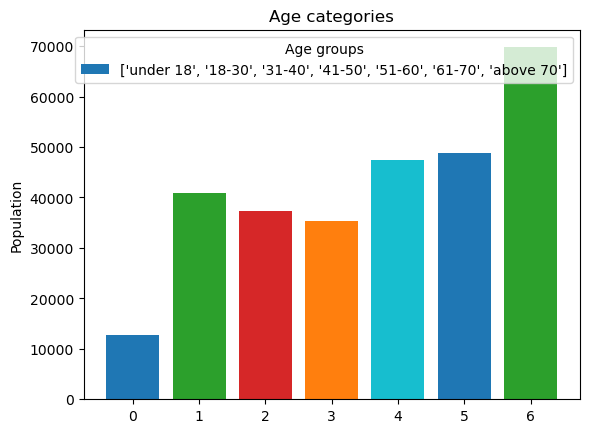

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()


age_counts = df['AGE'].value_counts()
age_counts=age_counts.sort_index()
bar_labels = ['under 18', '18-30', '31-40', '41-50','51-60', '61-70', 'above 70']
bar_colors = ['tab:blue', 'tab:green', 'tab:red', 'tab:orange','tab:cyan', 'tab:blue', 'tab:green']
ax.bar(age_counts.index,age_counts.values, label=bar_labels, color=bar_colors)

ax.set_ylabel('Population')
ax.set_title('Age categories')
ax.legend(title='Age groups')

plt.show()

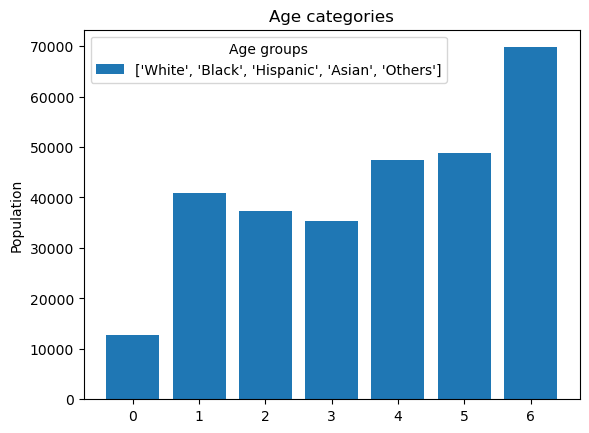

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()


race_counts = df['RACE'].value_counts()
race_counts=age_counts.sort_index()
bar_labels = ['White', 'Black', 'Hispanic', 'Asian','Others','Missing']
#bar_colors = ['tab:blue', 'tab:green', 'tab:red', 'tab:orange','tab:cyan', 'tab:blue', 'tab:green']
ax.bar(age_counts.index,age_counts.values, label= bar_labels)

ax.set_ylabel('Population')
ax.set_title('Age categories')
ax.legend(title='Age groups')

plt.show()

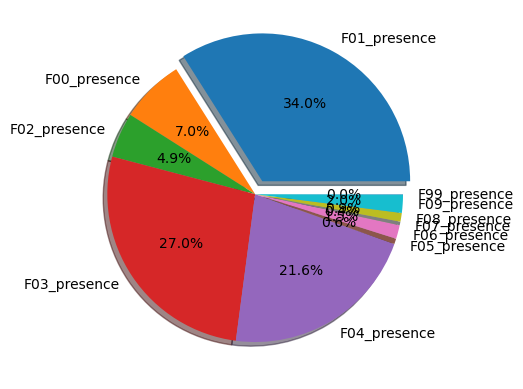

In [686]:
# whole dataset
# get the number of times column is not zero 
not_zero=[]
for f in pres:
    y = np.count_nonzero(df[f]) 
    not_zero.append(y)

explode = ( 0.1,0, 0, 0,0,0,0,0,0,0,0)
plt.pie(not_zero, labels = pres,  autopct='%1.1f%%',  explode=explode, shadow = True)

plt.show() 
print(count_list)


In [671]:
f001_sub= list(df['F01_presence'].value_counts())
df['F01_presence'].unique()


def list_to_percentage(f001_sub):
    return [(x)/sum(f001_sub) for x in f001_sub]
f01_percent=list_to_percentage(f001_sub)
print(f01_percent)

[0.763958399029532, 0.14287395533614072, 0.05019516486036697, 0.024174189352915706, 0.012011654065569961, 0.004623000635209944, 0.0016159378852186193, 0.00041039692323012553, 0.00011014329189632046, 2.2632183266367217e-05, 3.017624435515629e-06, 1.5088122177578146e-06]


In [690]:
f001_sub

[506331, 94693, 33268, 16022, 7961, 3064, 1071, 272, 73, 15, 2, 1]

In [ ]:
explode = ( 0.1,0, 0, 0,0,0,0,0,0,0,0)

plt.pie(f001, labels = pres,  autopct='%1.1f%%',  explode=explode, shadow = True)
# plt.legend(title = "F categories")
# plt.legend(bbox_to_anchor=(1.10, 1.2), loc='upper left', borderaxespad=0)
plt.show() 
print(count_list)

In [1]:
## for all rows dataset (no filtering)
df= df.astype('category')
df[['F01_presence',
 'F00_presence',
 'F02_presence',
 'F03_presence',
 'F04_presence',
 'F05_presence',
 'F06_presence',
 'F07_presence',
 'F08_presence',
 'F09_presence',
 'F99_presence']].describe().transpose()

F01_presence
1     94693
2     33268
3     16022
4      7961
5      3064
6      1071
7       272
8        73
9        15
10        2
11        1
dtype: int64


<AxesSubplot:xlabel='F01_presence'>

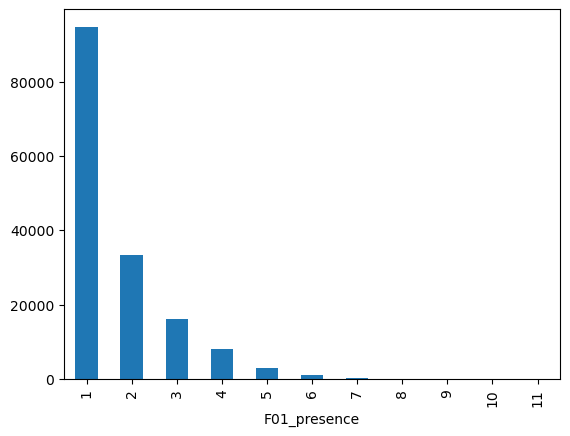

In [567]:
# Counting the occurrences of each unique category
GroupedData=df.groupby(by='F01_presence').size()
print(GroupedData)
 
# Generating a bar chart for a single column
%matplotlib inline
GroupedData.plot.bar()